In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ytree


from PIL import Image
from IPython.display import display

In [2]:
a = ytree.load('../data/y_tree_data/ahf_halos/snap_N64L16_000.parameter')
fn = a.save_arbor()
a = ytree.load(fn)

Additional features and improved performance (usually) by saving this arbor with "save_arbor" and reloading:
	>>> a = ytree.load("../data/y_tree_data/ahf_halos/snap_N64L16_000.parameter")
	>>> fn = a.save_arbor()
	>>> a = ytree.load(fn)


Getting fields [1 / ~1]: 100%|█████████████████████████████████████████████████████| 1937/1937 [00:04<00:00, 439.54it/s]
yt : [INFO     ] 2023-09-29 17:35:45,447 Saving field data to yt dataset: arbor/arbor_0000.h5.
yt : [INFO     ] 2023-09-29 17:35:45,550 Saving field data to yt dataset: arbor/arbor.h5.


# Single merge implementation using list

In [3]:
#arbor merger history extractor, it takes as input arbor = a[0]
def get_arbor_merge_history_no_multiple_merger(arbor):
    
    #first we get the main progenitor of the arbor, this is in root -> leaves order
    progenitor_root_to_leaves = list(arbor['prog'])

    #we want the leaves -> root order for all of our data
    progenitor_leaves_to_root = progenitor_root_to_leaves[::-1]
    
    #merge_history contains the pruned branch
    merge_history = []
    #progenitor_parallel_to_merge_history contains the element of the progenitor that are parallel to the merge_history
    progenitor_parallel_to_merge_history = []
   
    #now we prune the arbor and keep the branch that are not the progenitor of the arbor, we will need the index i
    for i in range( len(progenitor_leaves_to_root) ):
        
        #if the difference in the number of nodes bewteen two consecutive node in the progenitor_leaves_to_root is bigger than 1 it means that there is another branch:
        l_i = len(list(progenitor_leaves_to_root[i]['tree']))
        l_i_old = len(list(progenitor_leaves_to_root[i-1]['tree']))
        if l_i - l_i_old > 1:
                mh = [j for j in list(progenitor_leaves_to_root[i]['tree']) if j['uid'] not in list(progenitor_leaves_to_root[i-1]['tree', 'uid']) ]
                
                #f now is in root->leaves, we need to invert it to have leaves->root
                merge_history.append(mh[::-1])
                
                #we take also the progenitor parallel to the merge_history branch mh that we are considering right now
                ppmh = progenitor_leaves_to_root[i-len(mh):i]
                progenitor_parallel_to_merge_history.append(ppmh)
    
    return merge_history, progenitor_parallel_to_merge_history

In [4]:
merge_history, progenitor_parallel_to_merge_history = get_arbor_merge_history_no_multiple_merger(a[0])

for x in zip(merge_history[0], progenitor_parallel_to_merge_history[0]):
    print(x, '\n')

(TreeNode[28662], TreeNode[28668]) 

(TreeNode[28539], TreeNode[28557]) 

(TreeNode[28413], TreeNode[28436]) 

(TreeNode[28268], TreeNode[28309]) 

(TreeNode[28119], TreeNode[28173]) 

(TreeNode[27957], TreeNode[28026]) 

(TreeNode[27793], TreeNode[27863]) 

(TreeNode[27609], TreeNode[27693]) 

(TreeNode[27306], TreeNode[27504]) 



# Multi merge implementation using dictionary 

In [5]:
di = {
    'redshift': [1, 2]   
}

di['redshift'] 

[1, 2]

In [6]:
di_1 = {
    'redshift': []
}

di_1['redshift'].append(1)

di_1

{'redshift': [1]}

In [7]:
di_2 = {
    1: [1,2],
    2: [3, 4]
}

print(di_2[2])

for i in di_2.keys():
    print(di_2[i])

[3, 4]
[1, 2]
[3, 4]


In [8]:
di_2.keys()

dict_keys([1, 2])

In [9]:
di_3 = {
 1: {2: {3:[1,2]}}   
}

In [10]:
di_3[1][2][1]={3:[2, 3]}

In [11]:
print(di_3)

{1: {2: {3: [1, 2], 1: {3: [2, 3]}}}}


In [12]:
di_4 = {
'event_number': {0:[],
                 1:[]
                }
}


In [13]:
di_4['event_number'][0]

[]

# Multi merge implementation using Dataframe

In [81]:
#arbor merger history extractor, it takes as input isolated Treenode like a[0] 
def get_arbor_merge_history(isolated_TreeNode):
    
    df = pd.DataFrame(columns = ['merge_index', 'redshift', 'merge_header', 'mass_merge_header', 'mass_progenitor_parallel_to_merge_header', 'merge_branch', 'progenitor_parallel_to_merge_branch'])

    #first we get the main progenitor of the arbor, this is in root -> leaves order
    progenitor_root_to_leaves = list(isolated_TreeNode['prog'])

    #we want the leaves -> root order for all of our data
    progenitor_leaves_to_root = progenitor_root_to_leaves[::-1]
    
   
    merge_index = 0
    #now we prune the arbor and keep the branch that are not the progenitor of the arbor, we will need the index i
    for i in range( len(progenitor_leaves_to_root) ):
        
        #if the difference in the number of nodes bewteen two consecutive node in the progenitor_leaves_to_root is bigger than 1 it means that there is another branch:
        l_i = len(list(progenitor_leaves_to_root[i]['tree']))
        l_i_old = len(list(progenitor_leaves_to_root[i-1]['tree']))
        if l_i - l_i_old > 1:
            
            pruned_branches = [j for j in list(progenitor_leaves_to_root[i]['tree']) if j['uid'] not in list(progenitor_leaves_to_root[i-1]['tree', 'uid']) ]
            # merge_header = [j for j in list(progenitor_leaves_to_root[i]['tree']) if j['redshift'] == progenitor_leaves_to_root[i-1]['redshift'] and j['uid'] not in list(progenitor_leaves_to_root[i-1]['tree', 'uid'])]
            merge_header = [j for j in pruned_branches if j['redshift'] == progenitor_leaves_to_root[i-1]['redshift'] ]
            for m_h in merge_header:
                merge_branch = [j for j in pruned_branches if j['uid'] in m_h['tree', 'uid']]
                redshift_merge_branch = [j['redshift'] for j in merge_branch]
                  
                progenitor_parallel_to_merge_branch = [j for j in progenitor_leaves_to_root[:i] if j['redshift'] <= max(redshift_merge_branch) and j['redshift'] >= min(redshift_merge_branch) ]
                
                df.loc[len(df)] = [merge_index, m_h['redshift'], merge_header, m_h['mass'], progenitor_leaves_to_root[i-1]['mass'], merge_branch[::-1], progenitor_parallel_to_merge_branch]
                
            merge_index += 1
    
    return df

In [41]:
merge_history_df = get_arbor_merge_history(a[0])
merge_history_df

,merge_index,redshift,merge_header,mass_merge_header,mass_progenitor_parallel_to_merge_header,merge_branch,progenitor_parallel_to_merge_branch
0,0,3.875,[TreeNode[27609]],64133100000.0 Msun/h,1272710000000.0 Msun/h,"[TreeNode[28662], TreeNode[28539], TreeNode[28...","[TreeNode[28557], TreeNode[28436], TreeNode[28..."
1,1,2.500,[TreeNode[24434]],69661800000.0 Msun/h,1727170000000.0 Msun/h,"[TreeNode[26592], TreeNode[26321], TreeNode[26...","[TreeNode[26372], TreeNode[26108], TreeNode[25..."
2,2,2.400,[TreeNode[23741]],72979000000.0 Msun/h,1836640000000.0 Msun/h,"[TreeNode[26832], TreeNode[26584], TreeNode[26...","[TreeNode[26627], TreeNode[26372], TreeNode[26..."
3,3,2.350,[TreeNode[23360]],87353700000.0 Msun/h,1897450000000.0 Msun/h,"[TreeNode[24077], TreeNode[23711], TreeNode[23...","[TreeNode[23878], TreeNode[23524], TreeNode[23..."
4,4,1.300,[TreeNode[14847]],622533000000.0 Msun/h,15166400000000.0 Msun/h,"[TreeNode[20203], TreeNode[19807], TreeNode[19...","[TreeNode[20173], TreeNode[19776], TreeNode[19..."
5,5,1.200,[TreeNode[13946]],3242040000000.0 Msun/h,18113200000000.0 Msun/h,"[TreeNode[26796], TreeNode[27717], TreeNode[27...","[TreeNode[27693], TreeNode[27504], TreeNode[27..."
6,6,1.100,[TreeNode[13079]],3371410000000.0 Msun/h,19354900000000.0 Msun/h,"[TreeNode[13507], TreeNode[13079]]","[TreeNode[13502], TreeNode[13074]]"
7,7,1.050,[TreeNode[12638]],4024900000000.0 Msun/h,20057100000000.0 Msun/h,"[TreeNode[19724], TreeNode[19312], TreeNode[18...","[TreeNode[26372], TreeNode[26108], TreeNode[25..."
8,8,1.000,[TreeNode[12198]],3698710000000.0 Msun/h,19284200000000.0 Msun/h,"[TreeNode[12639], TreeNode[12198]]","[TreeNode[12633], TreeNode[12192]]"
9,9,0.900,[TreeNode[11615]],95093900000.0 Msun/h,19970800000000.0 Msun/h,"[TreeNode[22313], TreeNode[21929], TreeNode[21...","[TreeNode[22090], TreeNode[21712], TreeNode[21..."


## If there are merge_branch that are created by the merge of multiple halos
It is possible to recover their structure, and plot by using iterativly `get_arbor_merge_history` to obtain another merger_history_df for the merger branch. It could be possible to use this procedure in a for loop on the merge branches for untill all the branch are analyzide and the merger_history_dfs are all empty (no more merge)

In [42]:
for i in range(13):
    if len(merge_history_df.loc[i]['merge_branch']) == len(merge_history_df.loc[i]['progenitor_parallel_to_merge_branch']): 
        print(i, len(merge_history_df.loc[i]['merge_branch']), len(merge_history_df.loc[i]['progenitor_parallel_to_merge_branch']), 'the merging branch is made of one branch')
    else:
        print(i, len(merge_history_df.loc[i]['merge_branch']), len(merge_history_df.loc[i]['progenitor_parallel_to_merge_branch']), 'the merging branch is made of multiple converging branch')

0 8 8 the merging branch is made of one branch
1 8 8 the merging branch is made of one branch
2 11 11 the merging branch is made of one branch
3 3 3 the merging branch is made of one branch
4 14 14 the merging branch is made of one branch
5 41 40 the merging branch is made of multiple converging branch
6 2 2 the merging branch is made of one branch
7 90 37 the merging branch is made of multiple converging branch
8 2 2 the merging branch is made of one branch
9 27 27 the merging branch is made of one branch
10 9 9 the merging branch is made of one branch
11 5 5 the merging branch is made of one branch
12 126 69 the merging branch is made of multiple converging branch


### let's try with the 5th merging halo

In [78]:
p = ytree.TreePlot(merge_history_df[merge_history_df['merge_index']==5]['merge_branch'].to_list()[0][-1],dot_kwargs={'rankdir': 'LR', 'size': '"12,4"'} )
p.save('test_tree_merge_branch.png')

'test_tree_merge_branch.png'

In [79]:
im = Image.open('test_tree_merge_branch.png')
display(im)

In [80]:
test_df = get_arbor_merge_history(merge_history_df[merge_history_df['merge_index']==5]['merge_branch'].to_list()[0][-1])
test_df

,merge_index,redshift,merge_header,mass_merge_header,mass_progenitor_parallel_to_merge_header,merge_branch,progenitor_parallel_to_merge_branch
0,0,3.375,[TreeNode[26796]],53075600000.0 Msun/h,390327000000.0 Msun/h,[TreeNode[26796]],"[TreeNode[26796], TreeNode[26640]]"


### let's try with the 7th merger

In [91]:
p = ytree.TreePlot(merge_history_df[merge_history_df['merge_index']==7]['merge_branch'].to_list()[0][-1],dot_kwargs={'rankdir': 'LR', 'size': '"12,4"'} )
p.save('test_tree_merge_branch.png')

'test_tree_merge_branch.png'

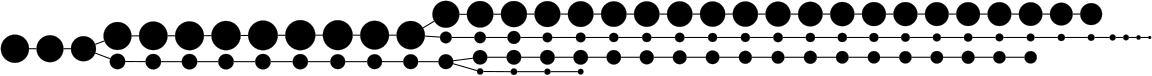

In [92]:
im = Image.open('test_tree_merge_branch.png')
display(im)

In [94]:
test_df = get_arbor_merge_history(merge_history_df[merge_history_df['merge_index']==7]['merge_branch'].to_list()[0][-1])
test_df

,merge_index,redshift,merge_header,mass_merge_header,mass_progenitor_parallel_to_merge_header,merge_branch,progenitor_parallel_to_merge_branch
0,0,1.65,[TreeNode[17904]],158121000000.0 Msun/h,3190070000000.0 Msun/h,"[TreeNode[26616], TreeNode[26341], TreeNode[26...","[TreeNode[25213], TreeNode[24898], TreeNode[24..."
1,1,1.20,[TreeNode[14029]],337252000000.0 Msun/h,3838030000000.0 Msun/h,"[TreeNode[19724], TreeNode[19312], TreeNode[18...","[TreeNode[24562], TreeNode[24220], TreeNode[23..."
